In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR

In [11]:
# 用于 DataLoader 的 transform
transform = transforms.Compose([
    transforms.ToTensor()
])


dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Split into train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should be at least 1
print(torch.cuda.get_device_name(0))  # Should print "GeForce GTX 1660 Ti"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()


True
1
NVIDIA GeForce GTX 1660 Ti


In [12]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1) # 3x3 kernel, stride 1
        self.conv2 = nn.Conv2d(6, 10, kernel_size=3, stride=1)
        self.fc = nn.Linear(10 * 24 * 24, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = BaselineCNN().to(device)

# Xavier Initialization
for layer in model.modules():
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(layer.weight)


In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

train_losses, val_losses = [], []
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(100):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(images), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            loss = criterion(model(images), labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter > 5:
            print("Early stopping.")
            break


Epoch 1, Train Loss: 0.2076, Val Loss: 0.1049
Epoch 2, Train Loss: 0.0818, Val Loss: 0.0966
Epoch 3, Train Loss: 0.0599, Val Loss: 0.0822
Epoch 4, Train Loss: 0.0449, Val Loss: 0.0832
Epoch 5, Train Loss: 0.0379, Val Loss: 0.0896
Epoch 6, Train Loss: 0.0307, Val Loss: 0.0976
Epoch 7, Train Loss: 0.0236, Val Loss: 0.0951
Epoch 8, Train Loss: 0.0189, Val Loss: 0.1259
Epoch 9, Train Loss: 0.0228, Val Loss: 0.1176
Early stopping.


In [14]:
import numpy as np

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 97.99%


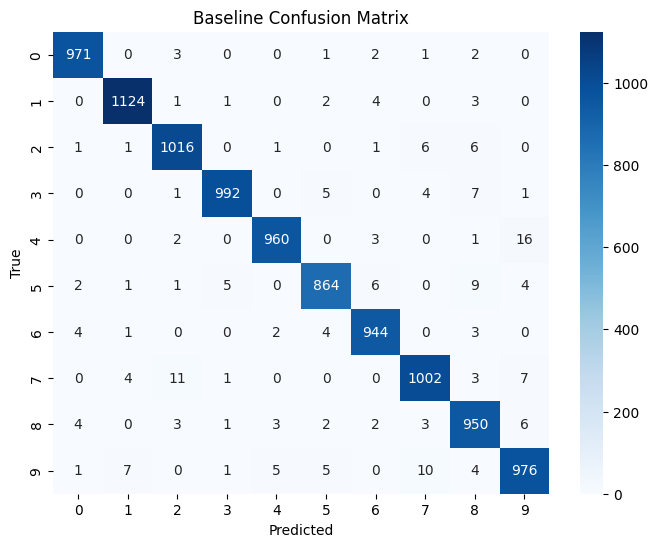

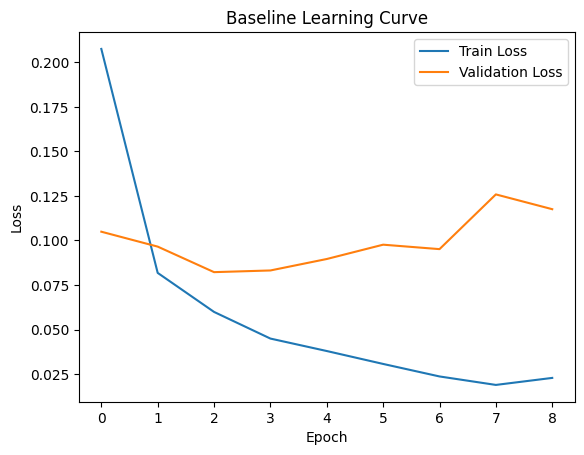

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Baseline Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Baseline Learning Curve')
plt.show()

It is a bit overfitting, because as train loss decreases, the validation loss increrases at around epoch 4

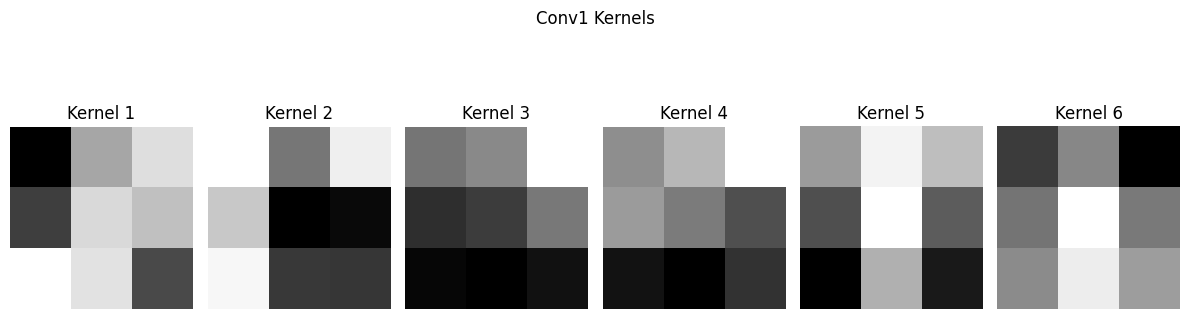

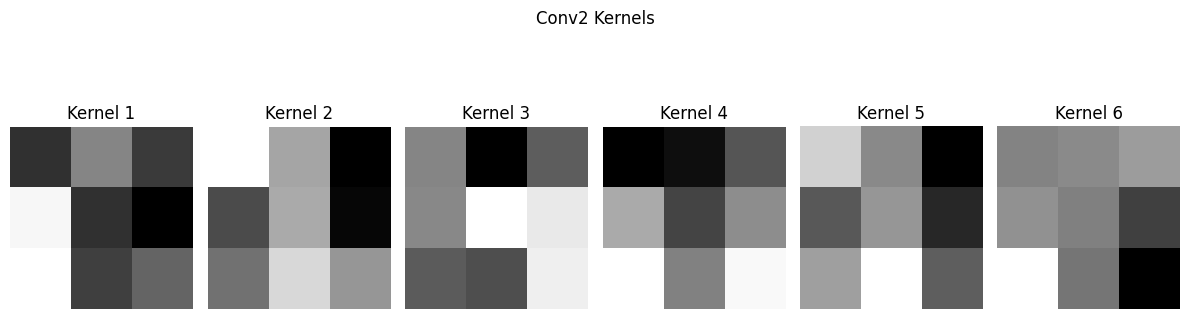

In [18]:
# Visualize a subset of kernels from conv1
def visualize_kernels(layer, title, num_kernels=6):
    with torch.no_grad():
        kernels = layer.weight.cpu().numpy()  # shape: (out_channels, in_channels, H, W)
        fig, axes = plt.subplots(1, num_kernels, figsize=(12, 4))
        fig.suptitle(title)

        for i in range(num_kernels):
            kernel = kernels[i, 0]  # visualize the first input channel
            axes[i].imshow(kernel, cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'Kernel {i+1}')

        plt.tight_layout()
        plt.show()

visualize_kernels(model.conv1, title="Conv1 Kernels", num_kernels=6)
visualize_kernels(model.conv2, title="Conv2 Kernels", num_kernels=6)